In [1]:
import numpy as np
import ot
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
from sklearn.datasets import make_moons
# User functions
from utils import BaseTransport, GaussianTransport, get_trajectories_for_plotting, get_desiderata, W2_dist
from IPython.display import Markdown

In [2]:
### Global Hyperparameters
n_samples = 300
n_samples_showing = 100
rng = np.random.RandomState(42)

In [3]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper")
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
point_alpha_value = 1
trajectory_parms = {'alpha': 0.15, 'linewidth': 2, 'zorder':10}
mpl.rcParams['lines.markersize'] = 8  # a global parameter for marker sizes
X_parms = {'color': pal[1], 'alpha':point_alpha_value, 'marker':'D', 'zorder':20}
Y_parms = {'color': pal[0], 'alpha':point_alpha_value, 'marker':'v', 'zorder':0}
Z_parms = {'color': pal[2], 'alpha':point_alpha_value, 'marker':'^', 'zorder':30}
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
contour_parms = {'linewidths':3}
cluster_markers = list('8s*Xd.HP')  # a list of keywords for matploblib markers 
if save_figures:
    figure_dir = Path('.') / 'figures' / 'gaussian-toy-problems'  # saves all figures in a figure directory in the local directory
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [4]:
def gaussian_contour_plot(X, mean, cov, label, colors, contour_kwargs=None, show=False, legend=False):
    # Ploting contours of the true given normal distribution
    x_min = np.min(X[:, 0]) - 0.25 * np.max(X[:, 0].std())
    y_min = np.min(X[:, 1]) - 0.25 * np.max(X[:, 1].std())
    x_max = np.max(X[:, 0]) + 0.25 * np.max(X[:, 0].std())
    y_max = np.max(X[:, 1]) + 0.25 * np.max(X[:, 1].std())

    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)
    XX, YY = np.meshgrid(xx, yy)
    coordinates = np.array([XX.flatten(), YY.flatten()]).T

    
    coordinate_probabilities = multivariate_normal(mean, cov).pdf(coordinates)
    if contour_kwargs:
        contour_plot = plt.contour(XX, YY, coordinate_probabilities.reshape(XX.shape),
                                   cmap=colors, **contour_kwargs)
    else:
        contour_plot = plt.contour(XX, YY, coordinate_probabilities.reshape(XX.shape),
                           cmap=colors, linewidths=2)
    contour_plot.collections[-3].set_label(label)
    if legend: plt.legend(loc='lower right')
    if show: plt.show()
    return None

# Explaining Gaussian Shifts
Here we are going to look at simple Gaussian shifts to cover two cases which illuminate the tradeoffs between the two atomic dataset shift explanation techinques: feature constrained shift and clustering. We will start with the simplest shift which is mean shift and then a shifted guassian mixture model

## Mean Shift
This is the case where our targest distribution has similar (or even the same) dependencies as our source distribution, but with change in the mean values

In [5]:
# Setting up data
source_mean = np.zeros(2)
source_cov = rng.randint(-2, 2, size=(2,2)) + np.eye(2)
source_cov = source_cov.T @ source_cov

target_mean = source_mean + [12, 6]
target_cov = source_cov.copy()

X = rng.multivariate_normal(source_mean, source_cov, size=n_samples)
Y = rng.multivariate_normal(target_mean, target_cov, size=n_samples)

# Since it can be confusing/ugly if we plot all samples we are only going to plot a random subset for clarity
points_to_show = rng.choice(n_samples, size=n_samples_showing, replace=False)

In [6]:
Z = X + (target_mean - source_mean)  # Mean Shift

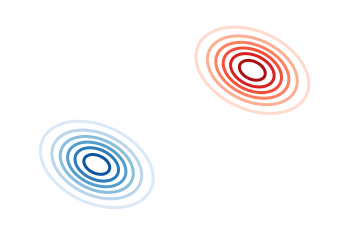

Fid: 177.464, Par: 0.000, Inter: max


In [7]:
gaussian_contour_plot(X, source_mean, source_cov, label='Source', colors='Blues', contour_kwargs=contour_parms)
gaussian_contour_plot(Y, target_mean, target_cov, label='Target', colors='Reds', contour_kwargs=contour_parms)
# gaussian_contour_plot(Z, Z.mean(0), np.cov(Z, rowvar=False),
#                       label=r'$T_{mean}(X)$', colors='Greens', contour_kwargs=contour_parms)

if not add_axis: plt.axis('off')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'shifted-gaussian-contour-plot.{save_parms["format"]}', **save_parms)
plt.show()
_ = get_desiderata(X, Y, Z=X, inter='max')

The mean(s) of feature(s) [0] have shifted by [12.] respectively.
Fid: 38.545, Par: 41673.105, Inter: 2


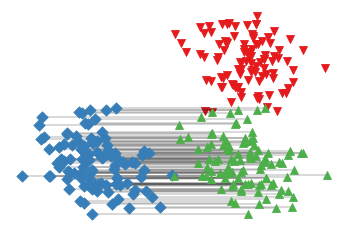




The mean(s) of feature(s) [0 1] have shifted by [12.  6.] respectively.
Fid: 0.000, Par: 53239.333, Inter: 1


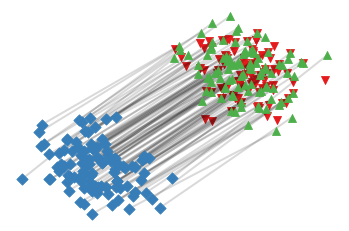

In [8]:
mean_deltas = target_mean - source_mean
# An argsort of mean shift across dims (e.g. the 0th position in the array has the largest shift in mean)
sorted_shifts = mean_deltas.argsort()[::-1]

for interpretability in range(X.shape[1], 0, -1):
    n_changable_dims = X.shape[1] - interpretability + 1
    changed_features = np.sort(sorted_shifts[:n_changable_dims])
    changed_by = mean_deltas[changed_features]
    print(f'The mean(s) of feature(s) {changed_features} have shifted by {changed_by} respectively.')
    T = BaseTransport(X, Y)
    Z_constrained = T.feature_forward(X, changed_features)
    Z_trajectories = get_trajectories_for_plotting(X, Z_constrained, points_to_show)
    plt.scatter(*X[points_to_show].T, **X_parms)
    plt.scatter(*Y[points_to_show].T, **Y_parms)
    plt.scatter(*Z_constrained[points_to_show].T, **Z_parms)
    plt.plot(*Z_trajectories, **trajectory_parms, color='black')
    get_desiderata(X, Y, Z_constrained, inter=interpretability)
    if add_title: plt.title(fr'Gussian mean shift with $\mathcal{{A}}={changed_features}$')
    if not add_axis: plt.axis('off')
    if add_legend: plt.legend()
    if save_figures: plt.savefig(figure_dir / f'gaussian-mean-shift-{n_changable_dims}-changed.{save_parms["format"]}', **save_parms)
    plt.show()
    print('\n\n')

## Gaussian Mixture Model

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
def generate_gaussian_mixture_circle(n_mixtures, n_samples_per_mixture, radius,
                                     return_parms=False, rng=None, jitter=False):
    # Generates an evenly distributed circle of gaussian distributions with a defined radius and a random cov
    rng = check_random_state(rng)
    # generating means of a each mixture, where each mean is a point on a circle with given radius
    uniform_pis = [2*np.pi * (i / n_mixtures) for i in range(n_mixtures)]
    if jitter is not False:
        jitter = rng.uniform(-jitter, jitter, size=(n_mixtures, 2))
    else:
        jitter =  np.zeros((n_mixtures, 2))
        
    mixture_centers = np.zeros((n_mixtures, 2))
    mixture_centers[:, 0], mixture_centers[:, 1] = np.cos(uniform_pis)*radius, np.sin(uniform_pis)*radius
    mixture_centers += jitter
    # generating a gaussian distribution for each mixture
    X = np.zeros((n_mixtures*n_samples_per_mixture, 2))  # 2_dims
    mixture_parameters = []
    mixture_labels = np.zeros(X.shape[0])
    for mixture_idx in range(n_mixtures):
        mixture_slice = [mixture_idx*n_samples_per_mixture, (mixture_idx+1)*n_samples_per_mixture]
        mixture_cov = rng.rand(2, 2) + np.eye(2)
        mixture_cov = mixture_cov @ mixture_cov.T
        X[mixture_slice[0]:mixture_slice[1]] = rng.multivariate_normal(mean=mixture_centers[mixture_idx],
                                                           cov=mixture_cov, size=n_samples_per_mixture)
        mixture_parameters.append( [mixture_centers[mixture_idx], mixture_cov] )
        mixture_labels[mixture_slice[0]: mixture_slice[1]] = mixture_idx
    if return_parms:
        return X, mixture_parameters, mixture_labels
    else:
        return X

In [11]:
# Hyper parameters
n_mixtures = 6
n_samples_per_mixture = 60
circle_radius = 10  # the radius of the circle of gaussians

In [12]:
X, X_mixture_parms, mixture_labels = generate_gaussian_mixture_circle(n_mixtures, n_samples_per_mixture,
                                                      circle_radius, rng=42, return_parms=True)
Y, Y_mixture_parms, _ = generate_gaussian_mixture_circle(n_mixtures, n_samples_per_mixture,
                                     circle_radius*2, rng=42, return_parms=True, jitter=5)
# Since it can be confusing/ugly if we plot all samples we are only going to plot a random subset for clarity
points_to_show = rng.choice(X.shape[0], size=n_samples_showing, replace=False)

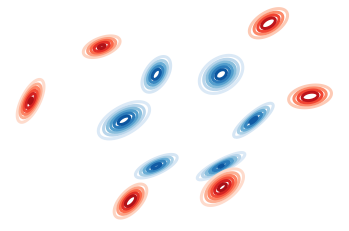

Fid: 106.281, Par: 0.000, Inter: max


In [13]:
#### Generating contour plot for mixture models
mixture_parms = contour_parms.copy()
mixture_parms['levels'] = 6
for mixture_idx in range(n_mixtures):
    gaussian_contour_plot(X[mixture_labels==mixture_idx], X_mixture_parms[mixture_idx][0], X_mixture_parms[mixture_idx][1],
                          label='Source', colors='Blues', contour_kwargs=mixture_parms)

    gaussian_contour_plot(Y[mixture_labels==mixture_idx], Y_mixture_parms[mixture_idx][0], Y_mixture_parms[mixture_idx][1],
                          label='Target', colors='Reds', contour_kwargs=mixture_parms)
if add_title: plt.title(fr'Gussian Mixture Model Components')
if not add_axis: plt.axis('off')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'gaussian-mixture-model-components-untouched.{save_parms["format"]}', **save_parms)
plt.show()
_ = get_desiderata(X, Y, Z=X, inter='max')

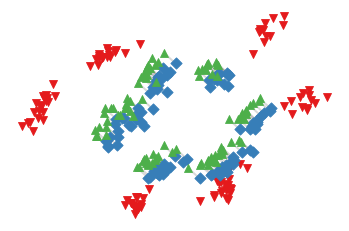

Fid: 99.090, Par: 2588.930, Inter: 1
The mean has shifted by [-1.81  1.98]





In [14]:
mixture_points_to_show = rng.choice(X.shape[0], size=n_samples_showing, replace=False)

# Showing pure mean shift:
Z = X + (Y.mean(axis=0) - X.mean(axis=0))

Z_trajectories = get_trajectories_for_plotting(X[mixture_points_to_show],
                                               Z[mixture_points_to_show])

plt.plot(*Z_trajectories, **trajectory_parms, color='black')
plt.scatter(*X[mixture_points_to_show].T, label='X', **X_parms)
plt.scatter(*Y[mixture_points_to_show].T, label='Y', **Y_parms)
plt.scatter(*Z[mixture_points_to_show].T, label=r'$T_\mu (X)', **Z_parms)



if add_title: plt.title(f'Mean Shift Transport')
if not add_axis: plt.axis('off')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'pure-mean-shift-{n_mixtures}-mixtures.{save_parms["format"]}', **save_parms)
plt.show()
# getting desiderata information
get_desiderata(X, Y, Z, inter=1)
with np.printoptions(precision=2):
    print(f'The mean has shifted by {Y.mean(axis=0) - X.mean(axis=0)}')
print('\n\n')

In [15]:
# # Fixing the number of a mixture components and increasing the number of clusters
# # to see the increase in fidelity and decrease in interpretability

# T = BaseTransport(X, Y)
# Z_OT = T.forward(X, Y)
# for n_clusters in range(1, n_mixtures+1):
#     plt.scatter(*Y[mixture_points_to_show].T, label='Y', **Y_parms)
#     Z_clusters, labels = T.cluster_forward(X, n_clusters, unconstrained_Z=Z_OT, return_labels=True)
#     for cluster_idx in range(n_clusters):
#         # plotting
#         cluster_points_to_show = mixture_points_to_show[labels[mixture_points_to_show] == cluster_idx]
# #         plt.scatter(*X[cluster_points_to_show].T, label=f'$X_{cluster_idx}$',
# #                     color=pal[cluster_idx+1], alpha=X_parms['alpha'], marker=cluster_markers[cluster_idx])
#         plt.scatter(*X[cluster_points_to_show].T, label=f'$X_{cluster_idx}$', **X_parms)
#         plt.scatter(*Z_clusters[cluster_points_to_show].T, label=f'$T(C_{{X_{cluster_idx}}})$',
#                     color=pal[cluster_idx+2], alpha=Z_parms['alpha'], marker=cluster_markers[cluster_idx])
# #         plt.scatter(*Z_clusters[cluster_points_to_show].T, label=f'$T(C_{{X_{cluster_idx}}})$',
# #                     color=Z_parms['color'], alpha=Z_parms['alpha'], marker=cluster_markers[cluster_idx])
#         cluster_trajactories = get_trajectories_for_plotting(X[cluster_points_to_show],
#                                                              Z_clusters[cluster_points_to_show])
#         plt.plot(*cluster_trajactories, color=pal[cluster_idx+2], **trajectory_parms)
# #         plt.plot(*cluster_trajactories, color=Z_parms['color'], **trajectory_parms)
#         with np.printoptions(precision=2):
#             cluster_mean_shift = X[cluster_points_to_show].mean(axis=0) - Z_clusters[cluster_points_to_show].mean(axis=0)
#             print(f'C_src_{cluster_idx} has shifted by {cluster_mean_shift}')
    
#     if add_title: plt.title(f'Mean Shift Transport of Clusters, $k={n_clusters}$')
#     if not add_axis: plt.axis('off')
#     if add_legend: plt.legend()
#     if save_figures: plt.savefig(figure_dir / f'cluster-transport-{n_clusters}-clusters-{n_mixtures}-mixtures.{save_parms["format"]}', **save_parms)
#     plt.show()
#     # getting desiderata information
#     get_desiderata(X, Y, Z_clusters, inter=n_clusters)
#     print('\n\n')

<span style="color: #1ac938">C_src_0 has shifted by [-1.81  1.98]</span>

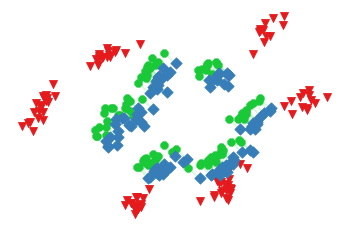

Fid: 99.090, Par: 2588.930, Inter: 1





<span style="color: #1ac938">C_src_0 has shifted by [5.43 3.35]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [-9.05  0.62]</span>

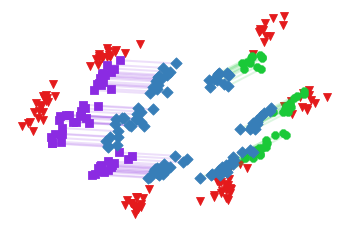

Fid: 44.822, Par: 22125.176, Inter: 2





<span style="color: #1ac938">C_src_0 has shifted by [8.03 6.93]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [-11.59   4.19]</span>

<span style="color: #9f480">C_src_2 has shifted by [-1.86 -5.18]</span>

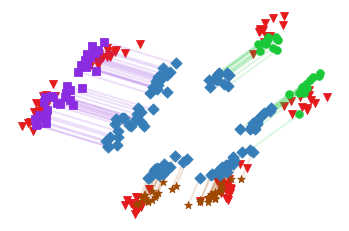

Fid: 8.056, Par: 35361.202, Inter: 3





<span style="color: #1ac938">C_src_0 has shifted by [-11.59   4.19]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [8.77 4.37]</span>

<span style="color: #9f480">C_src_2 has shifted by [-1.86 -5.18]</span>

<span style="color: #f14cc1">C_src_3 has shifted by [7.28 9.49]</span>

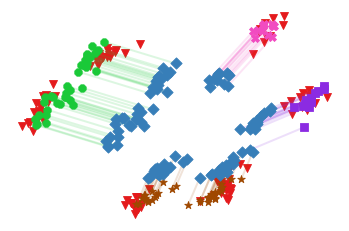

Fid: 5.690, Par: 36212.796, Inter: 4





<span style="color: #1ac938">C_src_0 has shifted by [-11.59   4.19]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [8.77 4.37]</span>

<span style="color: #9f480">C_src_2 has shifted by [-3.96 -6.54]</span>

<span style="color: #f14cc1">C_src_3 has shifted by [7.28 9.49]</span>

<span style="color: #a3a3a3">C_src_4 has shifted by [ 0.24 -3.82]</span>

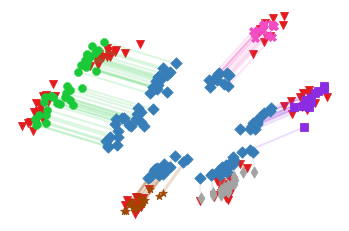

Fid: 3.607, Par: 36962.761, Inter: 5





<span style="color: #1ac938">C_src_0 has shifted by [7.28 9.49]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [-3.96 -6.54]</span>

<span style="color: #9f480">C_src_2 has shifted by [-14.35   3.75]</span>

<span style="color: #f14cc1">C_src_3 has shifted by [8.77 4.37]</span>

<span style="color: #a3a3a3">C_src_4 has shifted by [ 0.24 -3.82]</span>

<span style="color: #ffc40">C_src_5 has shifted by [-8.83  4.63]</span>

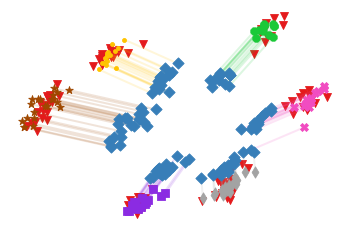

Fid: 0.998, Par: 37902.103, Inter: 6





In [16]:
# The same result as above, but in color this time!

def col_print(s, col):
    color = ''
    for c in col:
        color += str(hex(int(c*255)))[2:]
    display (Markdown(f'<span style="color: #{color}">{s}</span>'))

og_pal = sn.color_palette('Set1')
pal = list(sn.color_palette("bright"))
pal.pop(3)  # removing the red
X_parms = {'color': og_pal[1], 'alpha':point_alpha_value, 'marker':'D', 'zorder':20}
Y_parms = {'color': og_pal[0], 'alpha':point_alpha_value, 'marker':'v', 'zorder':0}
Z_parms = {'color': pal[2], 'alpha':point_alpha_value, 'marker':'^', 'zorder':30}

# Fixing the number of a mixture components and increasing the number of clusters
# to see the increase in fidelity and decrease in interpretability

T = BaseTransport(X, Y)
Z_OT = T.forward(X, Y)
for n_clusters in range(1, n_mixtures+1):
    plt.scatter(*Y[mixture_points_to_show].T, label='Y', **Y_parms)
    Z_clusters, labels = T.cluster_forward(X, n_clusters, unconstrained_Z=Z_OT, return_labels=True)
    for cluster_idx in range(n_clusters):
        # plotting
        cluster_points_to_show = mixture_points_to_show[labels[mixture_points_to_show] == cluster_idx]
#         plt.scatter(*X[cluster_points_to_show].T, label=f'$X_{cluster_idx}$',
#                     color=pal[cluster_idx+1], alpha=X_parms['alpha'], marker=cluster_markers[cluster_idx])
        plt.scatter(*X[cluster_points_to_show].T, label=f'$X_{cluster_idx}$', **X_parms)
        plt.scatter(*Z_clusters[cluster_points_to_show].T, label=f'$T(C_{{X_{cluster_idx}}})$',
                    color=pal[cluster_idx+2], alpha=Z_parms['alpha'], marker=cluster_markers[cluster_idx])
#         plt.scatter(*Z_clusters[cluster_points_to_show].T, label=f'$T(C_{{X_{cluster_idx}}})$',
#                     color=Z_parms['color'], alpha=Z_parms['alpha'], marker=cluster_markers[cluster_idx])
        cluster_trajactories = get_trajectories_for_plotting(X[cluster_points_to_show],
                                                             Z_clusters[cluster_points_to_show])
        plt.plot(*cluster_trajactories, color=pal[cluster_idx+2], **trajectory_parms)
#         plt.plot(*cluster_trajactories, color=Z_parms['color'], **trajectory_parms)
        with np.printoptions(precision=2):
            cluster_mean_shift =  Z_clusters[cluster_points_to_show].mean(axis=0) - X[cluster_points_to_show].mean(axis=0)
            col_print(f'C_src_{cluster_idx} has shifted by {cluster_mean_shift}', pal[cluster_idx+2])
    
    if add_title: plt.title(f'Mean Shift Transport of Clusters, $k={n_clusters}$')
    if not add_axis: plt.axis('off')
    if add_legend: plt.legend()
    if save_figures: plt.savefig(figure_dir / f'cluster-transport-{n_clusters}-clusters-{n_mixtures}-mixtures.{save_parms["format"]}', **save_parms)
    plt.show()
    # getting desiderata information
    get_desiderata(X, Y, Z_clusters, inter=n_clusters)
    print('\n\n')

In [17]:
# Reseting color stuff
pal = sn.color_palette('Set1')
X_parms = {'color': pal[1], 'alpha':point_alpha_value, 'marker':'D', 'zorder':20}
Y_parms = {'color': pal[0], 'alpha':point_alpha_value, 'marker':'v', 'zorder':0}
Z_parms = {'color': pal[2], 'alpha':point_alpha_value, 'marker':'^', 'zorder':30}

## Feature Shift
This is finding a transport map across a given number of dimensions, with the interpretation that the fewer dimensions we change, the more interpretable the mapping is.

In [18]:
data, labels = make_moons(n_samples*2, random_state=rng, noise=0.05)
X = data[labels==0]
Y = data[labels==1] - np.array([0, 1])  # the - [0, 1] is to visually seperate X, Y some more
moon_points_to_show = rng.choice(X.shape[0], size=n_samples_showing, replace=False)

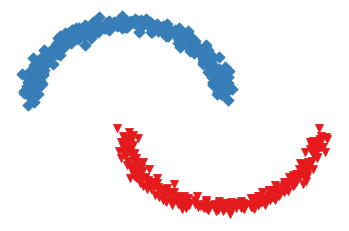

Fid: 4.380, Par: 0.000, Inter: max


In [19]:
plt.scatter(*X.T, **X_parms, label='Source')
plt.scatter(*Y.T, **Y_parms, label='Target')
if add_title: plt.title('two-moons')
if not add_axis: plt.axis('off')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'two-moons-untouched.{save_parms["format"]}', **save_parms)
plt.show()
_ = get_desiderata(X, Y, Z=X, inter='max')

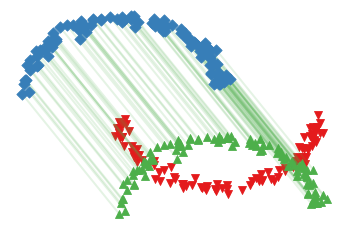

Fid: 0.240, Par: 1242.061, Inter: 1
The mean has shifted by [ 1.   -1.77]





In [20]:
# Showing pure mean shift:
Z = X + (Y.mean(axis=0) - X.mean(axis=0))
Z_trajectories = get_trajectories_for_plotting(X[moon_points_to_show],
                                               Z[moon_points_to_show])

plt.plot(*Z_trajectories, **trajectory_parms, color=Z_parms['color'])
plt.scatter(*X[moon_points_to_show].T, label='X', **X_parms)
plt.scatter(*Y[moon_points_to_show].T, label='Y', **Y_parms)
plt.scatter(*Z[moon_points_to_show].T, label=r'$T_\mu (X)', **Z_parms)



if add_title: plt.title(f'Mean Shift Transport')
if not add_axis: plt.axis('off')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'two-moons-pure-mean-shift.{save_parms["format"]}', **save_parms)
plt.show()
# getting desiderata information
get_desiderata(X, Y, Z, inter=1)
with np.printoptions(precision=2):
    print(f'The mean has shifted by {Y.mean(axis=0) - X.mean(axis=0)}')
print('\n\n')

In [21]:
def PercentExplained(X, Y, Z, W_X_Y=None, squared=False):
    if W_X_Y is None:
        W_X_Y = W2_dist(X, Y, squared)
    W_X_Z = W2_dist(Y, Z)
    return 100*(W_X_Y - W_X_Z) / W_X_Y  # given as a %

In [22]:
PercentExplained(X, Y, X + (Y.mean(axis=0) - X.mean(axis=0)))

88.30872442744881

Transporting along dim(s) [1]


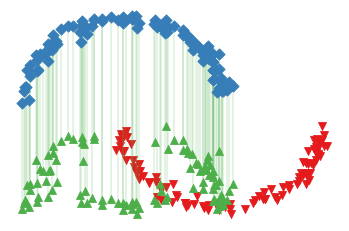

Fid: 1.070, Par: 988.301, Inter: 1
47.906671379386005




Transporting along dim(s) [0 1]


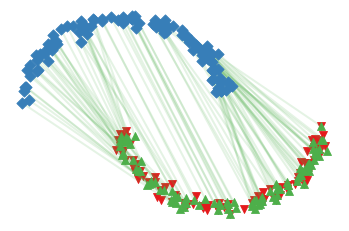

Fid: 0.000, Par: 1314.084, Inter: 2
100.0






In [23]:
T = BaseTransport(X, Y)
# we will start by transporting along one dimnesion
# this is picked via selecting the feature which has the largest mean shift
for n_free in range(1, X.shape[1]+1):
    active_set = np.argsort(Y.mean(axis=0) - X.mean(axis=0))[:n_free]
    print(f'Transporting along dim(s) {np.sort(active_set)}')
    Z_constrained = T.feature_forward(X, active_set)
    Z_trajectories = get_trajectories_for_plotting(X[moon_points_to_show],
                                                   Z_constrained[moon_points_to_show])
    plt.plot(*Z_trajectories, **trajectory_parms, color=Z_parms['color'])
    plt.scatter(*Y[moon_points_to_show].T, **Y_parms, label='Y')
    plt.scatter(*X[moon_points_to_show].T, **X_parms, label='X')
    plt.scatter(*Z_constrained[moon_points_to_show].T, **Z_parms, label=fr'$Z_{active_set}$')
    if add_title: plt.title(fr'Feature Transport, $\mathcal{{A}}={active_set}$')
    if not add_axis: plt.axis('off')
    if add_legend: plt.legend()
    if save_figures: plt.savefig(figure_dir / f'feature-transport-moons-{len(active_set)}-features.{save_parms["format"]}', **save_parms)
    plt.show()
    # getting desiderata information
    get_desiderata(X, Y, Z_constrained, inter=n_free)
    print(PercentExplained(X, Y, Z_constrained))
    print('\n\n\n')